In [1]:
import numpy as np
import _pickle as pickle

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm

In [6]:
import sys
sys.path.append('/home/submit/aqc/frb_project')
from illustris_frb import simulation

sim = simulation()

frb_zrange = (0.3, 0.4)
frb_mean_x = np.mean(sim.comoving_distance(frb_zrange))
frb_mean_z = sim.z_from_dist(frb_mean_x)
print(frb_mean_z)

0.3492729716291206


In [3]:
res_path = '/data/submit/submit-illustris/april/data/C_ells/trial_experiments.pkl'
with open(res_path, 'rb') as f:
    res = pickle.load(f)
print(list(res.keys()))

['regions', 'midslice_DMs', 'delta_gs', 'l', 'midslice_ClDg', 'midslice_DeltaCs', 'full_DMs', 'overlap_midslice', 'overlap_midslice_DeltaCs', 'overlap_fullz', 'overlap_fullz_DeltaCs', 'n_frbs_massweight', 'n_frbs_sfrweight', 'n_frbs_randpixels', 'DM_sfunc', 'DM_cutoffs', 'm_g_cutoffs', 'midslice_inj_hostDM_ClDgs', 'fid_inj_hostDM_ClDgs', 'proj_sfrweight_ClDgs', 'scatter_ClDgs', 'overlap']


In [4]:
ells = res['l']

midslice_ClDgs = res['midslice_ClDg']
midslice_DeltaCs = res['midslice_DeltaCs']

fid_ClDgs = res['n_frbs_sfrweight'][3000]

### plotting

In [2]:
colorcycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.style.use({
    'font.family':        'serif',
    'font.serif':         ['DejaVu Sans'],
    'mathtext.fontset':   'stixsans',
    'figure.figsize':     (6,4),
    'lines.markersize':   1.5,
    'text.usetex':        False,
    'figure.dpi':         120,
    'savefig.dpi':        250,
    'savefig.bbox':       'tight',
    'savefig.pad_inches': 0.1,
    'axes.prop_cycle':    plt.cycler('color', colorcycle)
})

In [48]:
# cross-correlation power spectrum plotting functions

def plot_xcorr(ells, C_ls, ax=None, label=None, color='k', lw=1, 
               ylim=None, DeltaCs=None, xlabel=r'$\ell$',
               ylabel=r'$C_l^{Dg}$', alpha=1, xscale='log', yscale='linear', **kwargs):

    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(ells, C_ls, lw=lw, color=color, alpha=alpha, **kwargs)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    ax.set_xlim((ells[0], ells[-1]))
    ax.set_ylim(ylim)

    if DeltaCs is not None:
        if len(DeltaCs)==2:
            ax.fill_between(ells, DeltaCs[0], DeltaCs[1], label=label, color=color, alpha=alpha*0.3)
        else:
            ax.fill_between(ells, C_ls-DeltaCs, C_ls+DeltaCs, label=label, color=color, alpha=alpha*0.3)

def plot_xcorr_trials(ells, C_l_list, ax=None, plotinterval=True, **kwargs):
    C_l_arr = np.vstack(C_l_list)
    if ax is None:
        fig, ax = plt.subplots()
    if plotinterval:
        interval = (np.percentile(C_l_arr, 16, axis=0), np.percentile(C_l_arr, 84, axis=0))
        plot_xcorr(ells, np.median(C_l_arr, axis=0), ax=ax, DeltaCs=interval, **kwargs)
    else:
        plot_xcorr(ells, np.mean(C_l_arr, axis=0), ax=ax, DeltaCs=np.std(C_l_arr, axis=0), **kwargs)

def plot_ref_ClDg(ax, ref_ClDg=midslice_ClDgs, lw1=0.7, lw2=0.5, color=None, label='default'):
    # plot_xcorr_trials(ells, midslice_ClDgs, ax=ax, color='k', lw=lw1)
    if label == 'default':
        if ref_ClDg is midslice_ClDgs:
            label = f'FRBs at uniform redshift (z = {frb_mean_z:.2f})'
        elif ref_ClDg is fid_ClDgs:
            label = f'Fiducial FRBs in star-forming galaxies'
    if color is None:
        if ref_ClDg is fid_ClDgs:
            color = 'purple'
        else:
            color='k'
    if lw1 > 0:
        ax.plot(ells, np.median(ref_ClDg, axis=0), color=color, lw=lw1, ls='--', label=label)
    if lw2 > 0:
        ax.plot(ells, np.percentile(ref_ClDg, 16, axis=0), color=color, lw=lw2, ls='--')
        ax.plot(ells, np.percentile(ref_ClDg, 84, axis=0), color=color, lw=lw2, ls='--')

def subplot_from_list(results_list, ref_ClDg=None, ref_label='default', ref_lws=(0.7, 0.5), labels=None, 
                      ax=None, colors=colorcycle, legend=True, alpha=0.9, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.axhline(0, color='gray', ls='dotted', lw=0.5)
    if ref_ClDg is not None:
        plot_ref_ClDg(ax, ref_ClDg, lw1=ref_lws[0], lw2=ref_lws[1], label=ref_label)
    for i, result in enumerate(results_list):
        plot_xcorr_trials(ells, result, ax=ax, label=labels[i], color=colors[i], alpha=alpha, **kwargs)
    if legend:
        ax.legend()

# plot a dictionary of ClDg arrays
def subplot_from_dict(results_dict, whichkeys=None, ref_ClDg=None, ref_label='default', ref_lws=(0.7, 0.5),
                     labels=None, ax=None, colors=colorcycle, legend=True, alpha=0.9, **kwargs):
    if whichkeys is None:
        whichkeys = list(results_dict.keys()) # which keys to plot
    if callable(labels):
        labels_ = [labels(key) for key in whichkeys]
    elif labels is None: # if no labels are given, default to dict keys
        labels_ = whichkeys
    else:
        labels_ = labels
    results_list = [results_dict[key] for key in whichkeys]
    subplot_from_list(results_list, ref_ClDg, ref_label, ref_lws, labels_, ax, colors, legend, alpha, **kwargs)

# plot a list of dictionaries of ClDg arrays, one dictionary per subplot
def generate_plots(results_dict_list, titles=None, figsize=None, whichkeys=None, ref_ClDg=None,
                   labels=None, colors=colorcycle, ylim=(-0.001, 0.0025), alpha=0.9, **kwargs):
    n = len(results_dict_list)
    if figsize is None:
        if n==2:
            figsize = (9,4)
        if n==3:
            figsize = (13,4)
    fig, axes = plt.subplots(1, n, figsize=figsize, sharex=True, sharey=True)
    for i, results_dict in enumerate(results_dict_list):
        subplot_from_dict(results_dict, whichkeys=whichkeys, ref_ClDg=ref_ClDg, 
                         labels=labels, ax=axes[i], colors=colors, **kwargs)
        if titles is not None:
            axes[i].set_title(titles[i])
    if ylim is not None:
        axes[0].set_ylim(ylim)
    for ax in axes[1:]:
        ax.set_ylabel('')
        
    plt.tight_layout()
    return fig, axes

## number of FRBs for multiple FRB placements

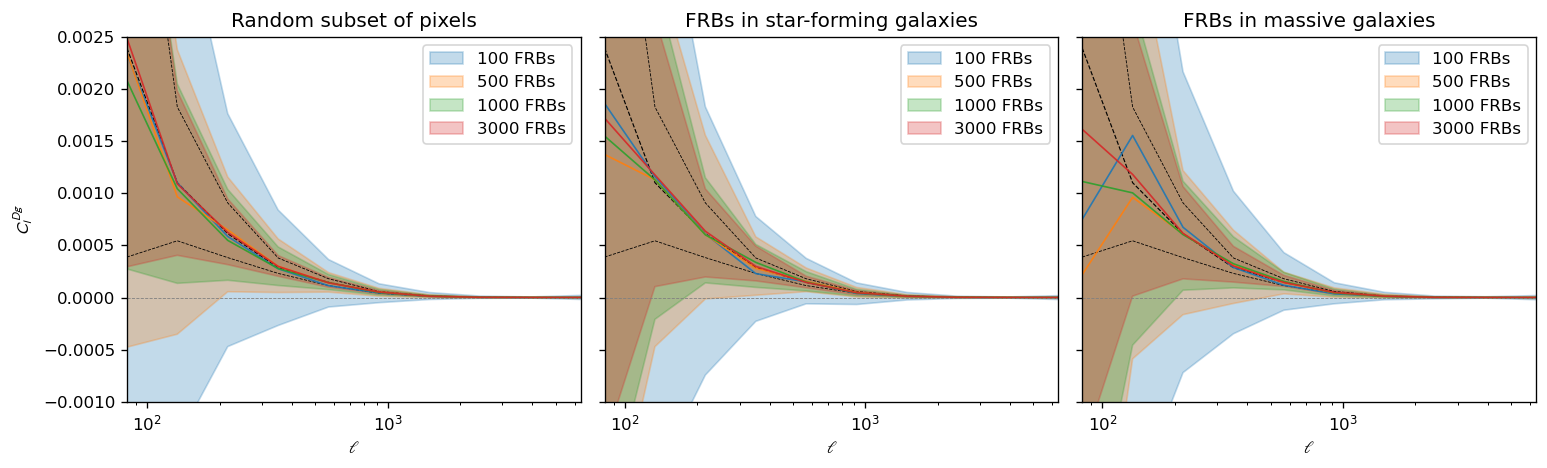

In [45]:
_ = generate_plots((res['n_frbs_randpixels'], res['n_frbs_sfrweight'],res['n_frbs_massweight']),
                   titles=('Random subset of pixels', 'FRBs in star-forming galaxies', 'FRBs in massive galaxies'),
                   whichkeys=(100, 500, 1000, 3000), ref_ClDg=midslice_ClDgs, labels=lambda x: f'{x} FRBs',
                   plotinterval=True)

## isolating effects of host DM and projected position

### host DM

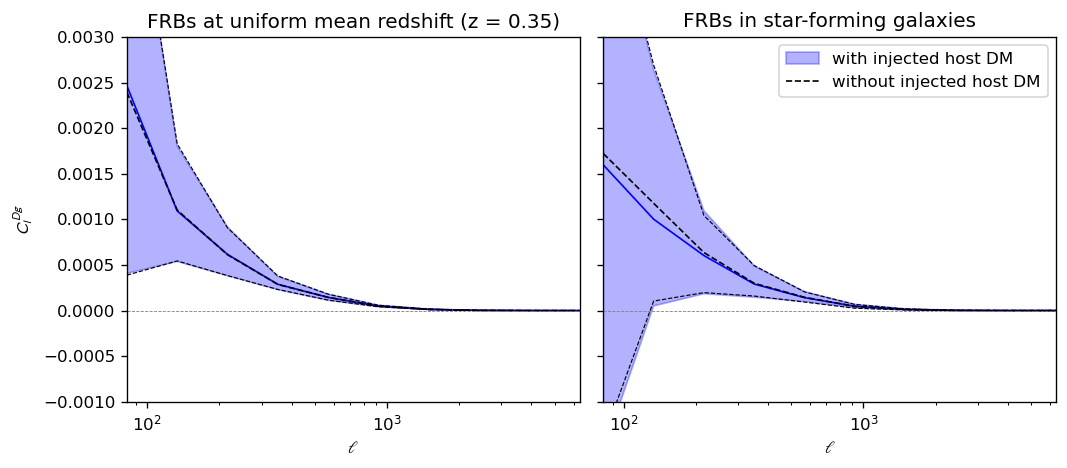

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)

# plt.suptitle('Cross-correlation with Injected Host DM', y=.97)

ax = axes[0]
ax.set_title(f'FRBs at uniform mean redshift (z = {frb_mean_z:.2f})')
plot_xcorr_trials(ells, res['midslice_inj_hostDM_ClDgs'], ax=ax, color='b', label='with injected host DM')
plot_ref_ClDg(ax, midslice_ClDgs, 1, 0.7, label='without injected host DM')
ax.axhline(0, color='gray', ls='--', lw=0.5)

ax = axes[1]
ax.set_title(f'FRBs in star-forming galaxies')
plot_xcorr_trials(ells, res['fid_inj_hostDM_ClDgs'], ax=ax, color='b', label='with injected host DM')
plot_ref_ClDg(ax, fid_ClDgs, 1, 0.7, label='without injected host DM')
ax.legend()
ax.axhline(0, color='gray', ls='--', lw=0.5)
ax.set_ylabel('')
ax.set_ylim(-0.001, 0.003)

plt.tight_layout()

Injecting a host DM does not really make a difference

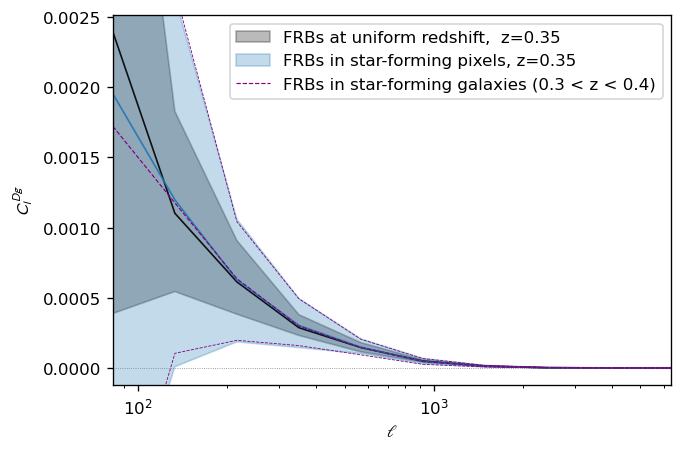

In [42]:
fig, ax = plt.subplots()
subplot_from_list((midslice_ClDgs, res['proj_sfrweight_ClDgs']), colors=('k', colorcycle[0]), ax=ax,
                  labels=(f'FRBs at uniform redshift,  z={frb_mean_z:.2f}', f'FRBs in star-forming pixels, z={frb_mean_z:.2f}'))
plot_ref_ClDg(ax, fid_ClDgs, label='FRBs in star-forming galaxies (0.3 < z < 0.4)')
ax.legend()

Projecting FRBs in pixels where there are star-forming galaxies is the dominant effect

## DM-dependent selection effects

### selection function

In [49]:
def sfunc(DMs, a=1): # fiducial selection function
    # a is how many factors to squish the selection function
    return np.exp( -(2/3)*(np.log10(DMs*a)-3)**2 )

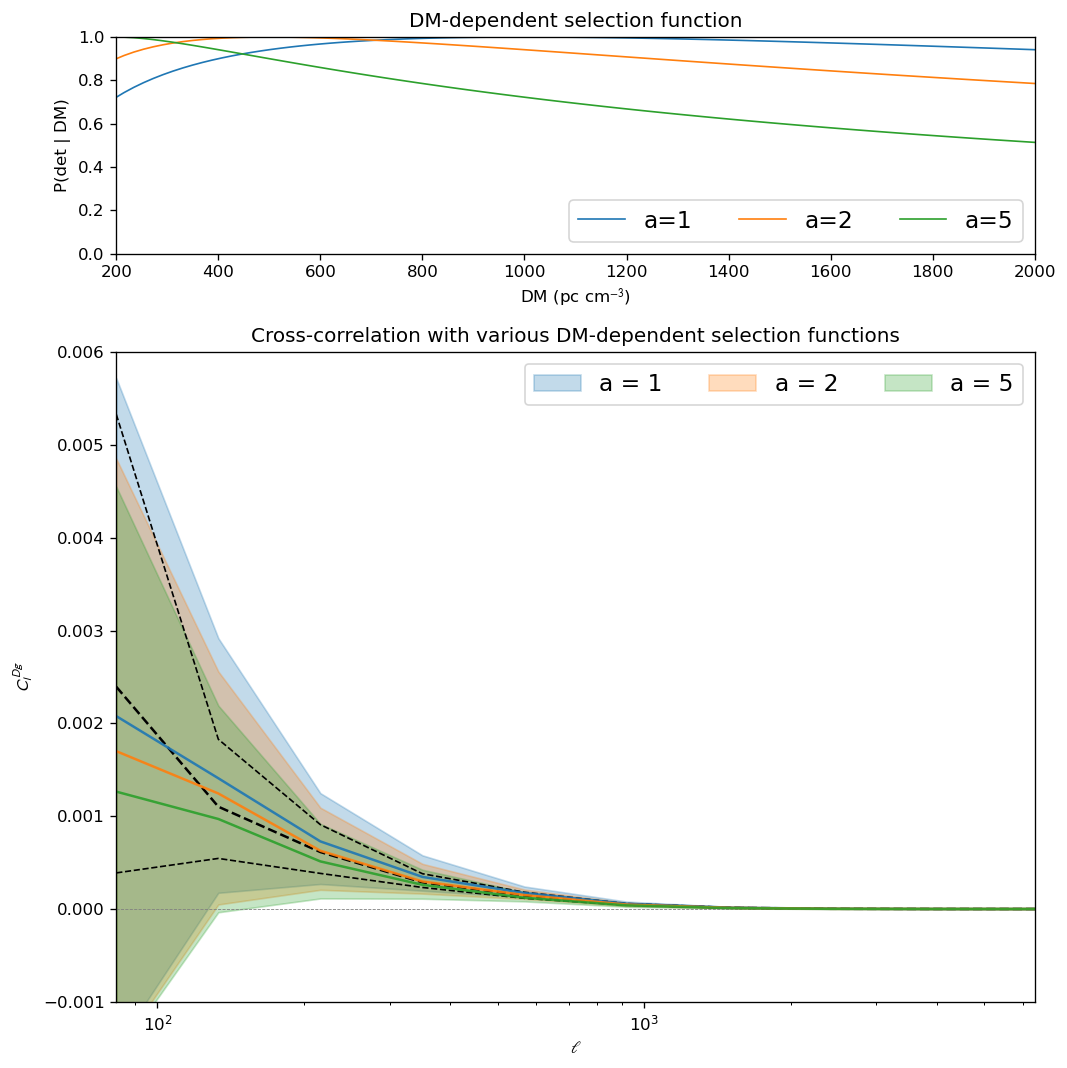

In [82]:
gs = GridSpec(2, 1, height_ratios=[1, 3])
fig = plt.figure(figsize=(9,9))

ax_s = fig.add_subplot(gs[0])
ax = fig.add_subplot(gs[1])

# upper plot that shows DM sfunc
DM_sfunc_res = res['DM_sfunc']
for i, a in enumerate(DM_sfunc_res.keys()):
    ax_s.plot(np.linspace(100, 2000, 100), sfunc(np.linspace(100, 2000, 100), a=a), color=colorcycle[i], lw=1, label=f'a={a}')
ax_s.set_title('DM-dependent selection function')
ax_s.set_xlabel('DM (pc ' + r'cm$^{-3}$)')
ax_s.set_ylabel('P(det | DM)')
ax_s.set_ylim(0,1)
ax_s.set_xlim(200, 2000)
ax_s.legend(fontsize=14, ncol=4, loc='lower right')

# plot cross correlation
subplot_from_dict(DM_sfunc_res, ref_ClDg=fid_ClDgs, ref_lws=(1.5, 1),
                 labels=lambda x: f'a = {x}', ax=ax, legend=False, lw=1.5, yscale='linear')
ax.legend(fontsize=14, ncol=4, loc='upper right')
ax.set_title('Cross-correlation with various DM-dependent selection functions')
# ax.set_xlim(200, 4000)
ax.set_ylim(-0.001, 0.006)

plt.tight_layout()

### DM cutoff

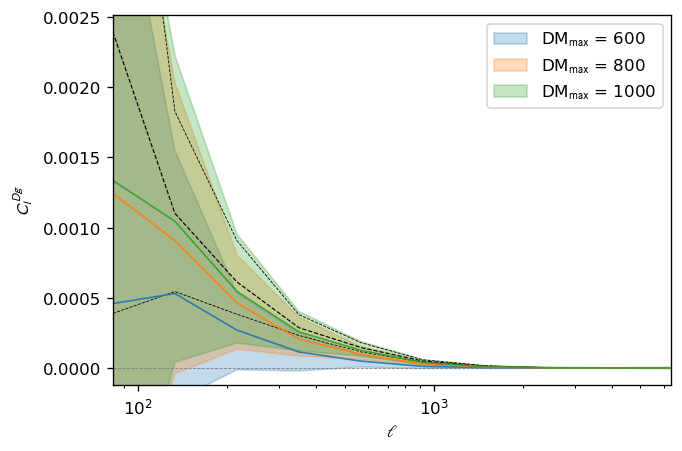

In [64]:
subplot_from_dict(res['DM_cutoffs'], labels=lambda x: r'DM$_\text{max}$ = '+str(x), yscale='linear')

## apparent magnitude cutoffs

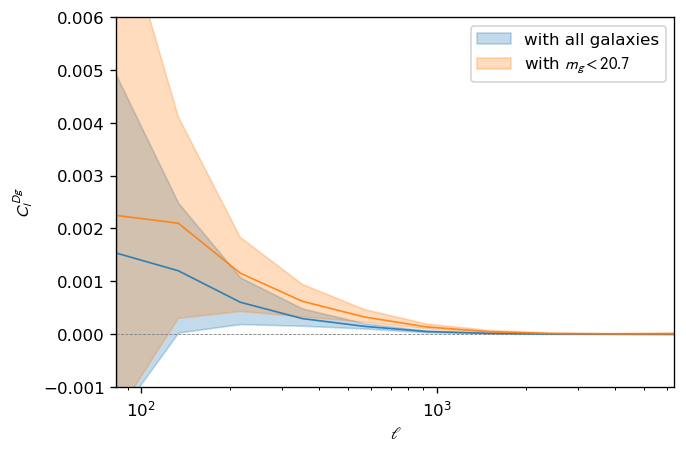

In [83]:
subplot_from_dict(res['m_g_cutoffs'], labels=('with all galaxies', 'with $m_g < 20.7$'), 
                 yscale='linear', ylim=(-0.001, 0.006))

## Scattering (impact parameter) selection effects

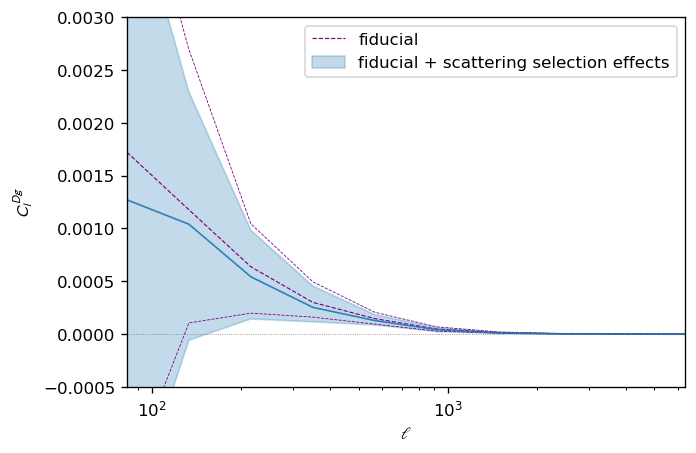

In [49]:
subplot_from_list((res['scatter_ClDgs'],), ref_ClDg=fid_ClDgs, ref_label='fiducial', labels=('fiducial + scattering selection effects',),
                  ylim=(-0.0005, 0.003))

## effect of redshift overlaps between FRBs and foreground galaxies

In [54]:
reversed(list(res['overlap'].keys()))

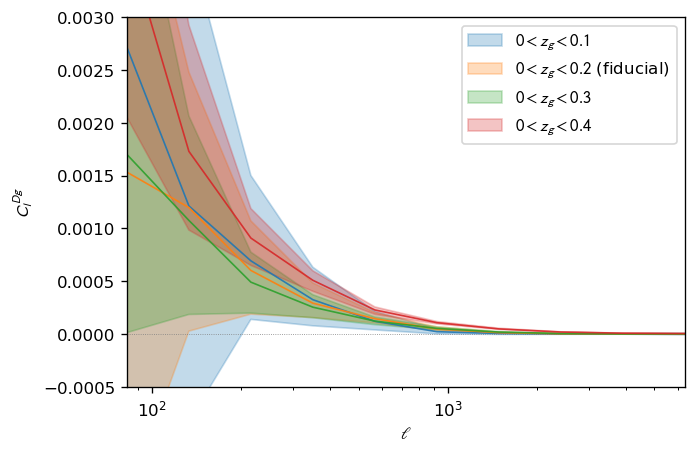

In [63]:
subplot_from_dict(res['overlap'],
                  labels=lambda x: f'${x[0]} < z_g < {x[1]}$' if x[1] != 0.2 else f'${x[0]} < z_g < {x[1]}$ (fiducial)', 
                  ylim=(-0.0005, 0.003))

Notable effect is that including the overlap boosts the signal (as expected). Would be interesting to see how this is affected by apparent magnitude galaxy cuts